In [1]:
# imports
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        #self.fc1 = nn.Linear(2304 , 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [6]:
# load model
model_dir = 'C:\\Users\\kdhome\\Documents\\progs\\torchvision_mnist_example\\'
model = Net()
model.load_state_dict(torch.load(os.path.join(model_dir, 'mnist_cnn.pt')))
model.eval();

RuntimeError: Error(s) in loading state_dict for Net:
	Missing key(s) in state_dict: "H1w", "H1b", "H2w", "H2b", "H3w", "H3b", "outw", "outb". 
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 

In [36]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets

In [50]:
torch.manual_seed(1337)
np.random.seed(1337)

for split in {'train', 'test'}:

    data = datasets.MNIST(model_dir, train=split=='train', download=True)

    n = 7291 if split == 'train' else 2007
    rp = np.random.permutation(len(data))[:n]

    X = torch.full((n, 1, 16, 16), 0.0, dtype=torch.float32)
    Y = torch.full((n, 10), -1.0, dtype=torch.float32)
    for i, ix in enumerate(rp):
        I, yint = data[int(ix)]
        # PIL image -> numpy -> torch tensor -> [-1, 1] fp32
        xi = torch.from_numpy(np.array(I, dtype=np.float32)) / 127.5 - 1.0
        # add a fake batch dimension and a channel dimension of 1 or F.interpolate won't be happy
        xi = xi[None, None, ...]
        # resize to (16, 16) images with bilinear interpolation
        xi = F.interpolate(xi, (16, 16), mode='bilinear')
        X[i] = xi[0] # store

        # set the correct class to have target of +1.0
        Y[i, yint] = 1.0
    print(X)
    print(Y)
    torch.save((X, Y), model_dir + split + '1989.pt')

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

In [51]:
# load data
Xtr, Ytr = torch.load(model_dir+'train1989.pt')
Xte, Yte = torch.load(model_dir+'test1989.pt')

In [41]:
def grid_mistakes(X, Y):
    
    plt.figure(figsize=(14, 4))
    ishow, nshow = 0, 14
    for ix in range(X.size(0)):
        x, y = X[[ix]], Y[[ix]]
        print(x.shape, y.shape)
        break
        yhat = model(x)
        yi = y.argmax()
        yhati = yhat.argmax()
        if yi != yhati:
            plt.subplot(2, 7, ishow+1)
            plt.imshow(x[0,0], cmap='gray')
            plt.title(f'gt={yi}, pred={yhati}')
            plt.axis('off')
            ishow += 1
            if ishow >= nshow:
                break

In [42]:
grid_mistakes(Xtr, Ytr) # training set mistakes

torch.Size([1, 1, 16, 16]) torch.Size([1, 10])


<Figure size 1400x400 with 0 Axes>

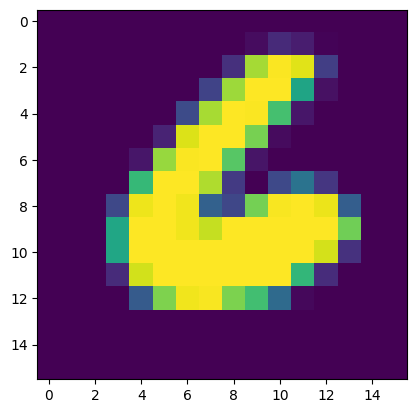

In [15]:
plt.imshow(Xtr[0][0])

In [30]:
Ytr[0].max(0).indices.item()

6

In [31]:
grid_mistakes(Xtr, Ytr) # training set mistakes

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2304 and 9216x128)

<Figure size 1400x400 with 0 Axes>

In [3]:
class Net(nn.Module):
    """ 1989 LeCun ConvNet per description in the paper """

    def __init__(self):
        super().__init__()

        # initialization as described in the paper to my best ability, but it doesn't look right...
        winit = lambda fan_in, *shape: (torch.rand(*shape) - 0.5) * 2 * 2.4 / fan_in**0.5
        macs = 0 # keep track of MACs (multiply accumulates)
        acts = 0 # keep track of number of activations

        # H1 layer parameters and their initialization
        self.H1w = nn.Parameter(winit(5*5*1, 12, 1, 5, 5))
        self.H1b = nn.Parameter(torch.zeros(12, 8, 8)) # presumably init to zero for biases
        assert self.H1w.nelement() + self.H1b.nelement() == 1068
        macs += (5*5*1) * (8*8) * 12
        acts += (8*8) * 12

        # H2 layer parameters and their initialization
        """
        H2 neurons all connect to only 8 of the 12 input planes, with an unspecified pattern
        I am going to assume the most sensible block pattern where 4 planes at a time connect
        to differently overlapping groups of 8/12 input planes. We will implement this with 3
        separate convolutions that we concatenate the results of.
        """
        self.H2w = nn.Parameter(winit(5*5*8, 12, 8, 5, 5))
        self.H2b = nn.Parameter(torch.zeros(12, 4, 4)) # presumably init to zero for biases
        assert self.H2w.nelement() + self.H2b.nelement() == 2592
        macs += (5*5*8) * (4*4) * 12
        acts += (4*4) * 12

        # H3 is a fully connected layer
        self.H3w = nn.Parameter(winit(4*4*12, 4*4*12, 30))
        self.H3b = nn.Parameter(torch.zeros(30))
        assert self.H3w.nelement() + self.H3b.nelement() == 5790
        macs += (4*4*12) * 30
        acts += 30

        # output layer is also fully connected layer
        self.outw = nn.Parameter(winit(30, 30, 10))
        self.outb = nn.Parameter(-torch.ones(10)) # 9/10 targets are -1, so makes sense to init slightly towards it
        assert self.outw.nelement() + self.outb.nelement() == 310
        macs += 30 * 10
        acts += 10

        self.macs = macs
        self.acts = acts

    def forward(self, x):

        # x has shape (1, 1, 16, 16)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        x = F.conv2d(x, self.H1w, stride=2) + self.H1b
        x = torch.tanh(x)

        # x is now shape (1, 12, 8, 8)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        slice1 = F.conv2d(x[:, 0:8], self.H2w[0:4], stride=2) # first 4 planes look at first 8 input planes
        slice2 = F.conv2d(x[:, 4:12], self.H2w[4:8], stride=2) # next 4 planes look at last 8 input planes
        slice3 = F.conv2d(torch.cat((x[:, 0:4], x[:, 8:12]), dim=1), self.H2w[8:12], stride=2) # last 4 planes are cross
        x = torch.cat((slice1, slice2, slice3), dim=1) + self.H2b
        x = torch.tanh(x)

        # x is now shape (1, 12, 4, 4)
        x = x.flatten(start_dim=1) # (1, 12*4*4)
        x = x @ self.H3w + self.H3b
        x = torch.tanh(x)

        # x is now shape (1, 30)
        x = x @ self.outw + self.outb
        x = torch.tanh(x)

         # x is finally shape (1, 10)
        return x

In [53]:
m = Net()

In [56]:
sd_hf = m.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

H1w torch.Size([12, 1, 5, 5])
H1b torch.Size([12, 8, 8])
H2w torch.Size([12, 8, 5, 5])
H2b torch.Size([12, 4, 4])
H3w torch.Size([192, 30])
H3b torch.Size([30])
outw torch.Size([30, 10])
outb torch.Size([10])


In [59]:
m = Net()
sd_hf = m.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

conv1.weight torch.Size([32, 1, 3, 3])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 3, 3])
conv2.bias torch.Size([64])
fc1.weight torch.Size([128, 9216])
fc1.bias torch.Size([128])
fc2.weight torch.Size([10, 128])
fc2.bias torch.Size([10])


In [7]:
class Net(nn.Module):
    """ 1989 LeCun ConvNet per description in the paper """

    def __init__(self):
        super().__init__()

        # initialization as described in the paper to my best ability, but it doesn't look right...
        winit = lambda fan_in, *shape: (torch.rand(*shape) - 0.5) * 2 * 2.4 / fan_in**0.5
        macs = 0 # keep track of MACs (multiply accumulates)
        acts = 0 # keep track of number of activations

        # H1 layer parameters and their initialization
        self.H1w = nn.Parameter(winit(5*5*1, 12, 1, 5, 5))
        self.H1b = nn.Parameter(torch.zeros(12, 8, 8)) # presumably init to zero for biases
        assert self.H1w.nelement() + self.H1b.nelement() == 1068
        macs += (5*5*1) * (8*8) * 12
        acts += (8*8) * 12

        # H2 layer parameters and their initialization
        """
        H2 neurons all connect to only 8 of the 12 input planes, with an unspecified pattern
        I am going to assume the most sensible block pattern where 4 planes at a time connect
        to differently overlapping groups of 8/12 input planes. We will implement this with 3
        separate convolutions that we concatenate the results of.
        """
        self.H2w = nn.Parameter(winit(5*5*8, 12, 8, 5, 5))
        self.H2b = nn.Parameter(torch.zeros(12, 4, 4)) # presumably init to zero for biases
        assert self.H2w.nelement() + self.H2b.nelement() == 2592
        macs += (5*5*8) * (4*4) * 12
        acts += (4*4) * 12

        # H3 is a fully connected layer
        self.H3w = nn.Parameter(winit(4*4*12, 4*4*12, 30))
        self.H3b = nn.Parameter(torch.zeros(30))
        assert self.H3w.nelement() + self.H3b.nelement() == 5790
        macs += (4*4*12) * 30
        acts += 30

        # output layer is also fully connected layer
        self.outw = nn.Parameter(winit(30, 30, 10))
        self.outb = nn.Parameter(-torch.ones(10)) # 9/10 targets are -1, so makes sense to init slightly towards it
        assert self.outw.nelement() + self.outb.nelement() == 310
        macs += 30 * 10
        acts += 10

        self.macs = macs
        self.acts = acts

    def forward(self, x):

        # x has shape (1, 1, 16, 16)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        x = F.conv2d(x, self.H1w, stride=2) + self.H1b
        x = torch.tanh(x)

        # x is now shape (1, 12, 8, 8)
        x = F.pad(x, (2, 2, 2, 2), 'constant', -1.0) # pad by two using constant -1 for background
        slice1 = F.conv2d(x[:, 0:8], self.H2w[0:4], stride=2) # first 4 planes look at first 8 input planes
        slice2 = F.conv2d(x[:, 4:12], self.H2w[4:8], stride=2) # next 4 planes look at last 8 input planes
        slice3 = F.conv2d(torch.cat((x[:, 0:4], x[:, 8:12]), dim=1), self.H2w[8:12], stride=2) # last 4 planes are cross
        x = torch.cat((slice1, slice2, slice3), dim=1) + self.H2b
        x = torch.tanh(x)

        # x is now shape (1, 12, 4, 4)
        x = x.flatten(start_dim=1) # (1, 12*4*4)
        x = x @ self.H3w + self.H3b
        x = torch.tanh(x)

        # x is now shape (1, 30)
        x = x @ self.outw + self.outb
        x = torch.tanh(x)

         # x is finally shape (1, 10)
        return x

In [10]:
model_dir = 'C:\\Users\\kdhome\\Documents\\progs\\torchvision_mnist_example\\out\\modern\\'
model = Net()
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.eval();

In [11]:
# load data
Xtr, Ytr = torch.load('train1989.pt')
Xte, Yte = torch.load('test1989.pt')

In [21]:
def grid_mistakes(X, Y):
    
    plt.figure(figsize=(14, 4))
    ishow, nshow = 0, 14
    for ix in range(X.size(0)):
        print(ix, X.shape)
        x, y = X[[ix]], Y[[ix]]
        yhat = model(x)
        yi = y.argmax()
        yhati = yhat.argmax()
        if yi != yhati:
            plt.subplot(2, 7, ishow+1)
            plt.imshow(x[0,0], cmap='gray')
            plt.title(f'gt={yi}, pred={yhati}')
            plt.axis('off')
            ishow += 1
            if ishow >= nshow:
                break

0 torch.Size([7291, 1, 16, 16])
1 torch.Size([7291, 1, 16, 16])
2 torch.Size([7291, 1, 16, 16])
3 torch.Size([7291, 1, 16, 16])
4 torch.Size([7291, 1, 16, 16])
5 torch.Size([7291, 1, 16, 16])
6 torch.Size([7291, 1, 16, 16])
7 torch.Size([7291, 1, 16, 16])
8 torch.Size([7291, 1, 16, 16])
9 torch.Size([7291, 1, 16, 16])
10 torch.Size([7291, 1, 16, 16])
11 torch.Size([7291, 1, 16, 16])
12 torch.Size([7291, 1, 16, 16])
13 torch.Size([7291, 1, 16, 16])
14 torch.Size([7291, 1, 16, 16])
15 torch.Size([7291, 1, 16, 16])
16 torch.Size([7291, 1, 16, 16])
17 torch.Size([7291, 1, 16, 16])
18 torch.Size([7291, 1, 16, 16])
19 torch.Size([7291, 1, 16, 16])
20 torch.Size([7291, 1, 16, 16])
21 torch.Size([7291, 1, 16, 16])
22 torch.Size([7291, 1, 16, 16])
23 torch.Size([7291, 1, 16, 16])
24 torch.Size([7291, 1, 16, 16])
25 torch.Size([7291, 1, 16, 16])
26 torch.Size([7291, 1, 16, 16])
27 torch.Size([7291, 1, 16, 16])
28 torch.Size([7291, 1, 16, 16])
29 torch.Size([7291, 1, 16, 16])
30 torch.Size([7291,

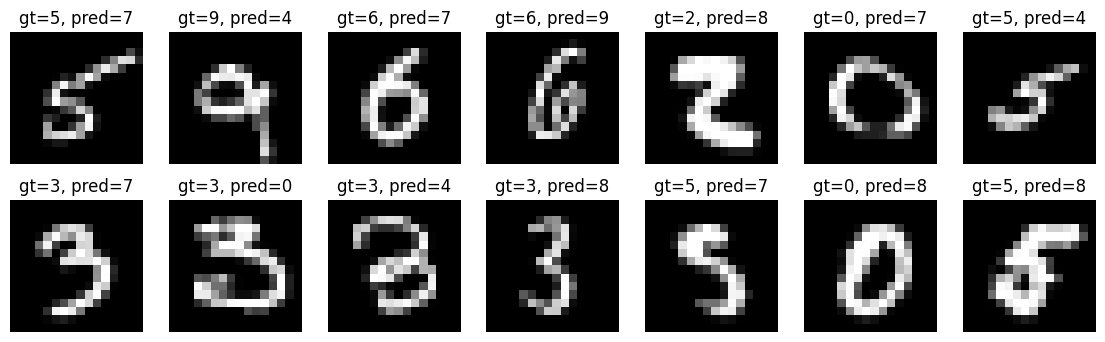

In [22]:
grid_mistakes(Xtr, Ytr) # training set mistakes


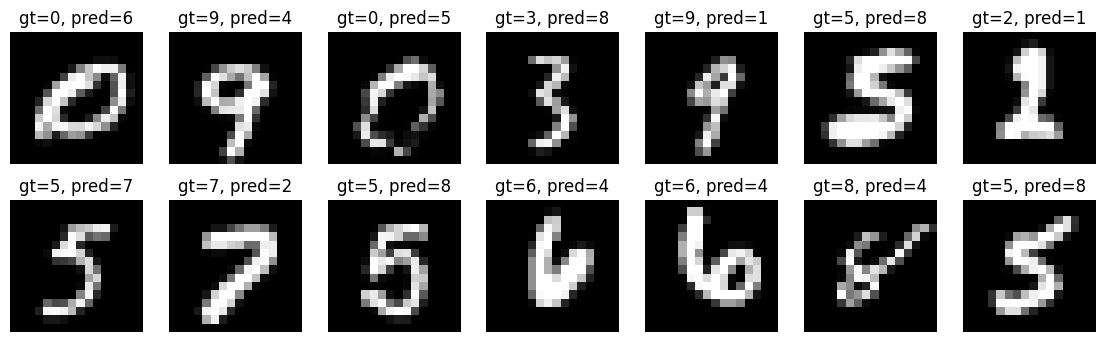

In [14]:
grid_mistakes(Xte, Yte) # test set mistakes

In [27]:
winit = lambda fan_in, *shape: (torch.rand(*shape) - 0.5) * 2 * 2.4 / fan_in**0.5
macs = 0 # keep track of MACs (multiply accumulates)
acts = 0 # keep track of number of activations

In [28]:
H1w = nn.Parameter(winit(5*5*1, 12, 1, 5, 5))
H1b = nn.Parameter(torch.zeros(12, 8, 8)) # presumably init to zero for biases
macs += (5*5*1) * (8*8) * 12
acts += (8*8) * 12

In [32]:
H1w.shape, H1b.shape

(torch.Size([12, 1, 5, 5]), torch.Size([12, 8, 8]))

In [34]:
macs, acts

(19200, 768)

In [35]:
H1w

Parameter containing:
tensor([[[[-0.4301,  0.0479,  0.4760,  0.3774, -0.3639],
          [ 0.1454,  0.2431, -0.1833,  0.3073,  0.1318],
          [-0.0098, -0.2873, -0.3971, -0.3653, -0.3906],
          [-0.4338, -0.3192,  0.2070, -0.2593, -0.4138],
          [ 0.0954, -0.1147, -0.2570,  0.2363, -0.0997]]],


        [[[-0.0883, -0.4203,  0.0285, -0.1807, -0.4012],
          [ 0.3291,  0.1493, -0.0094,  0.3502, -0.4136],
          [ 0.3382, -0.1510, -0.3728,  0.0988,  0.2929],
          [ 0.3957, -0.3832,  0.3803,  0.3535, -0.1249],
          [-0.0433, -0.1100, -0.1634,  0.3200,  0.2043]]],


        [[[ 0.2860,  0.4615, -0.2629, -0.2732, -0.0957],
          [ 0.2030, -0.2157, -0.3782,  0.1554, -0.2461],
          [ 0.1123, -0.0520,  0.3030, -0.1059, -0.4394],
          [ 0.0134,  0.3061, -0.1403, -0.4632, -0.1334],
          [-0.0482,  0.3401,  0.1026,  0.4431, -0.2458]]],


        [[[-0.0449,  0.2010, -0.2201, -0.0376, -0.2930],
          [-0.1671, -0.1098, -0.2247,  0.3286,  0.1447

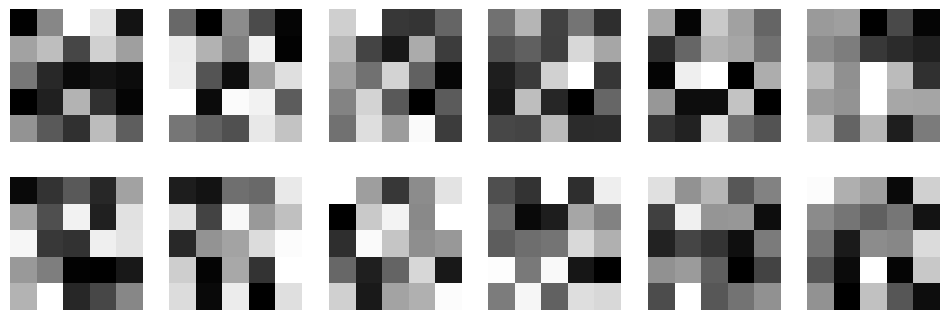

In [54]:
plt.figure(figsize=(12, 4))
ishow, nshow = 0, 12
for ix in range(H1w.size(0)):
    #print(ix, X.shape)
    #print(H1w[ix][0])
    x = H1w[ix][0]
    plt.subplot(2, 6, ishow+1)
    plt.imshow(x.detach(), cmap='gray')
    #plt.title(f'gt={yi}, pred={yhati}')
    plt.axis('off')
    ishow += 1
    if ishow >= nshow:
        break
 

In [36]:
H1w.shape

torch.Size([12, 1, 5, 5])

In [37]:
H1w.size(0)

12

In [48]:
H1w[0][0]

tensor([[-0.4301,  0.0479,  0.4760,  0.3774, -0.3639],
        [ 0.1454,  0.2431, -0.1833,  0.3073,  0.1318],
        [-0.0098, -0.2873, -0.3971, -0.3653, -0.3906],
        [-0.4338, -0.3192,  0.2070, -0.2593, -0.4138],
        [ 0.0954, -0.1147, -0.2570,  0.2363, -0.0997]],
       grad_fn=<SelectBackward0>)

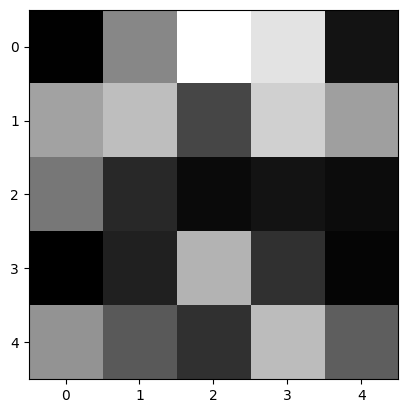

In [49]:
plt.imshow(H1w[0][0].detach(), cmap='gray')

In [55]:
# jak wyglada antropologia danych?

In [56]:
xs = torch.tensor([1314, 8513, 14885, 11, 2359, 11, 5897, 11, 8513, 47286, 11, 56610, 11, 34991, 1883, 271, 2359, 45043, 1234, 271, 395, 13754, 15257, 11, 350, 1074, 11, 3783, 8, 306, 29671, 46587, 47286, 1883, 309, 1238, 11, 3783, 314, 1238, 3552, 36452, 936, 3783, 3552, 36452, 446, 309, 56610, 58749, 41344, 1234, 309, 4733, 314, 2359, 4819, 446, 309, 6266, 314, 454, 1835, 680, 23902, 22485, 11, 3783, 446, 309, 6266, 151626, 1234, 309, 56610, 43723, 1234, 309, 538, 13754, 15257, 1851, 4966, 2659, 49009, 951, 220, 15, 734, 352, 2123, 706, 40309, 186515, 25, 9902, 35099, 8242, 12083, 16472, 27474, 15, 69, 93414, 15710, 59, 83, 49113, 25, 117746, 21, 69, 58336, 4078, 1607, 506, 34991, 11, 13754, 15257, 425, 4631, 4819, 936, 4631, 46587, 47286, 48314, 2313, 506, 220, 1353, 13, 425, 13754, 15257, 820, 4631, 46587, 47286, 936, 6266, 15732, 24521, 352, 538, 4966, 1380, 1102, 32268, 734, 506, 2338])

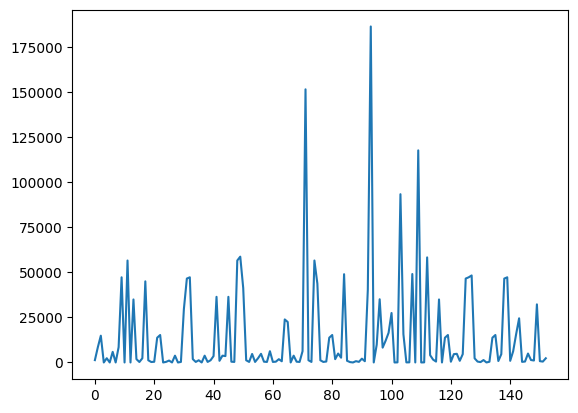

In [57]:
plt.plot(xs)

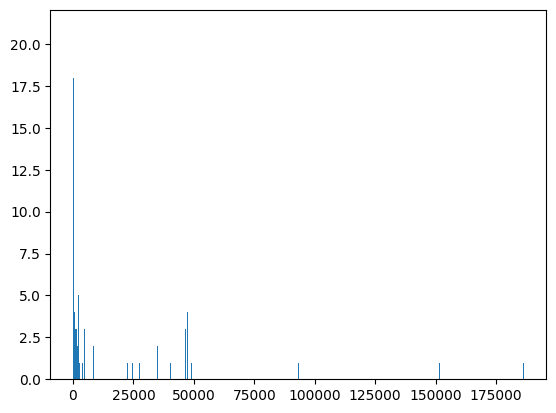

In [63]:
plt.hist(xs, bins=1000);

In [61]:
xs.float().var()

tensor(7.2106e+08)

In [64]:
xs2 = torch.tensor([3879, 26487, 11, 290, 2240, 120999, 198, 72, 40179, 2499, 976, 24195, 1076, 328, 448, 32315, 220, 40179, 28154, 17, 198, 20051, 2164, 198, 4579, 16602, 197, 30102, 220, 702, 11, 220, 4745, 24, 58, 17, 1592, 3538, 79803, 197, 30538, 220, 2029, 11, 220, 1179, 22, 58, 16, 1592, 100827, 656, 197, 105590, 11, 483, 6679, 499, 1989, 7969, 472, 20915, 13650, 198, 14882, 18167, 2775, 105590, 11, 40198, 11, 55601, 11, 11885, 104006, 11, 38952, 155810, 11, 601, 15190, 11, 169176, 124625, 198, 45015, 198, 6499, 13, 28391, 16523, 6251, 197, 1125, 220, 316, 220, 1353, 74297, 32035, 1592, 14179, 33, 40472, 197, 1125, 74297, 316, 220, 1434, 74297, 198, 1186, 4345, 197, 1398, 18189, 58, 18, 1592, 5352, 4345, 197, 1398, 18189, 58, 18, 1592, 36390, 3772, 4345, 197, 1398, 18189, 350, 41454, 2245, 220, 4217, 18189, 350, 140200, 13637, 18, 1592, 8865, 198, 43, 16, 11956, 197, 23, 44875, 316, 220, 1125, 44875, 198, 131547, 326, 39594, 198, 73410, 4596, 197, 16, 4403, 76, 316, 220, 6718, 43183, 198, 31066, 920, 21395, 7189, 12, 1125, 11, 59199, 12, 1398, 3463, 1215, 6818, 350, 25035, 395, 392, 131169, 1, 7015, 446, 50726, 35424, 198, 3248, 167784, 2775, 16, 13, 17, 58, 17, 60, 1585, 16, 13, 21, 5749, 198, 8037, 12, 55600, 197, 105590, 220, 39526, 6818, 131169, 198, 13081, 2775, 47, 16328, 350, 27768, 220, 16, 11, 220, 17, 11, 220, 18, 936, 220, 6514, 154393, 77170, 20174, 11, 220, 20021, 154393, 93319, 20174, 198, 13508, 198, 4319, 54010, 267, 197, 105590, 220, 33248, 198, 9909, 267, 22447, 299, 2883, 32242, 43266, 350, 47, 20, 446, 10768, 4495, 198, 71142, 198, 976, 32315, 220, 40179, 11, 30828, 11484, 575, 40179, 326, 1217, 5542, 472, 220, 39526, 7189, 11, 382, 261, 10449, 55600, 13, 1225, 382, 261, 7266, 81191, 2622, 7288, 316, 290, 32315, 220, 33248, 13, 623, 575, 40179, 673, 17882, 306, 220, 4745, 24, 13, 1225, 18627, 290, 19062, 13986, 328, 15600, 24686, 174120, 3992, 290, 220, 20811, 21, 328, 220, 5695, 23, 11, 290, 32315, 220, 24741, 7189, 328, 220, 4745, 17, 11, 326, 220, 4745, 20, 885, 575, 33248, 364, 3206, 673, 290, 1577, 68595, 3161, 99154, 2530, 22840, 60, 1215, 7189, 2364, 472, 1775, 472, 290, 1577, 1215, 7189, 23134, 316, 3931, 945, 1572, 1001, 5749, 1643, 167784, 13, 1225, 10877, 261, 4410, 402, 164847, 11956, 326, 448, 21781, 35887, 37909, 7670, 364, 5958, 480, 673, 11297, 11, 290, 4871, 6198, 673, 22257, 7269, 2870, 220, 1055, 326, 220, 455, 631, 5202, 391, 42020, 11, 2870, 220, 2991, 11, 1302, 326, 220, 3796, 11, 1302, 272, 2012, 783, 3617, 777, 3099, 11, 326, 2870, 220, 21, 13, 16, 326, 220, 23, 13, 17, 3503, 12, 56937, 13401, 1134, 5785, 72851, 777, 3099, 395, 2973, 220, 1161, 326, 220, 2546, 74297, 3926, 11308, 17, 60, 355, 19271, 220, 1434, 74297, 575, 40179, 119297, 220, 4987, 5749, 15543, 777, 3099, 415, 2012, 71914, 391, 42020, 326, 98190, 16336, 13632, 328, 220, 2092, 13, 24, 11308, 19, 60, 1225, 382, 16679, 18370, 472, 5661, 472, 290, 575, 33248, 503, 575, 31652, 777, 16523, 15839, 13, 623, 575, 40179, 885, 18055, 6198, 382, 11707, 316, 1617, 6468, 79301, 29412, 483, 722, 25699, 11608, 316, 261, 4590, 15839, 13, 623, 30843, 454, 12756, 7670, 402, 290, 23134, 673, 17000, 16107, 1572, 290, 575, 38202, 454, 12756, 777, 15839, 13, 623, 32315, 220, 38469, 6818, 454, 12756, 7109, 72, 38202, 1405, 673, 261, 13574, 11, 18297, 13324, 8039, 106510, 267, 484, 673, 15205, 306, 261, 109538, 15114, 26162, 290, 575, 33248, 364, 976, 575, 40179, 673, 53434, 656, 290, 4756, 37101, 2883, 13, 42063, 1504, 106770, 395, 290, 575, 40179, 402, 7561, 220, 1130, 11, 220, 1179, 22, 326, 290, 2174, 87290, 1504, 402, 8051, 220, 2029, 11, 220, 1179, 22, 11308, 16, 60])

In [65]:
xs2.float().var()

tensor(8.5679e+08)

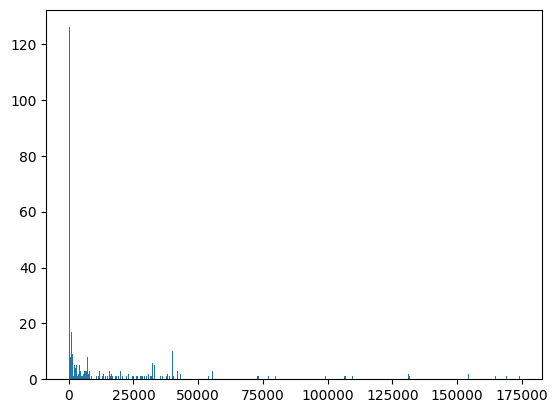

In [66]:
plt.hist(xs2, bins=1000);